<a href="https://colab.research.google.com/github/GenAIUnplugged/tensorflow_series/blob/main/Transfer_Learning_Tensorflow_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# flowers_transfer_learning.py

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 5

# Load the Flowers dataset
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Preprocessing function
def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    return image, label

# Prepare datasets
train_ds = train_ds.map(format_example).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Optional fine-tuning
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Save the model
model.save('flowers_mobilenetv2.h5')

# Plot training history
def plot_history(histories, titles):
    plt.figure(figsize=(12, 4))
    for i, (history, title) in enumerate(zip(histories, titles)):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'{title} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history([history, history_fine], ['Initial', 'Fine-tuned'])


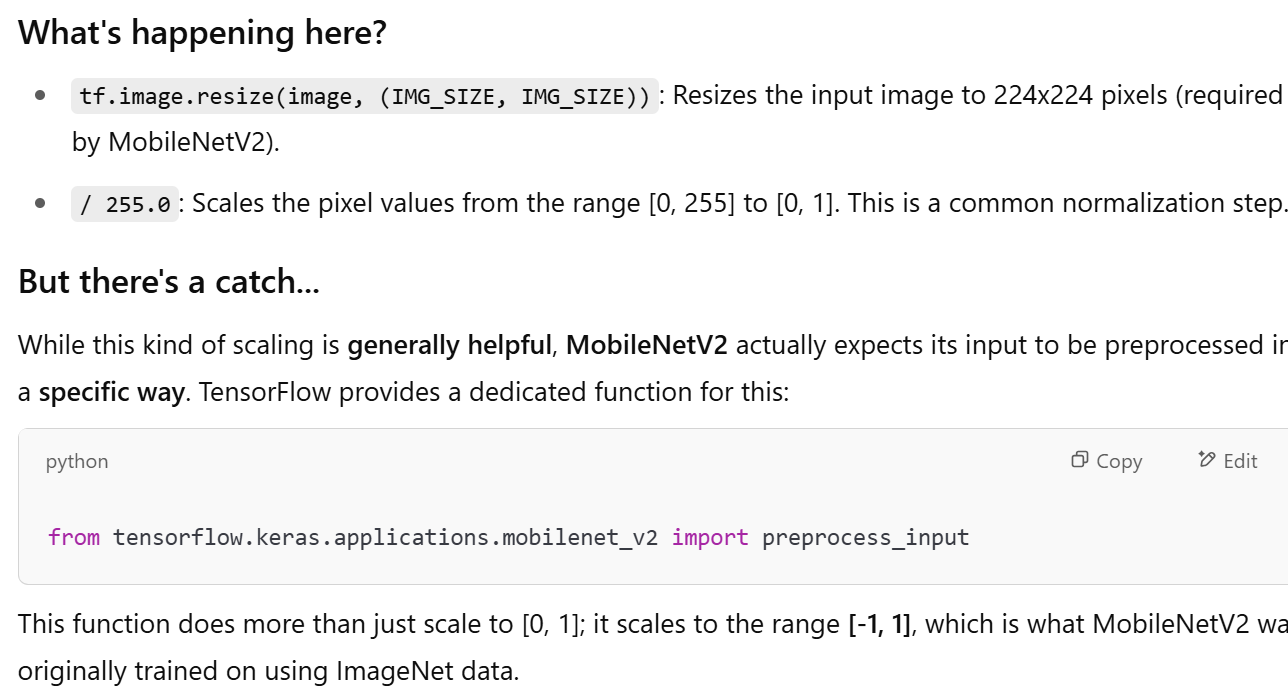

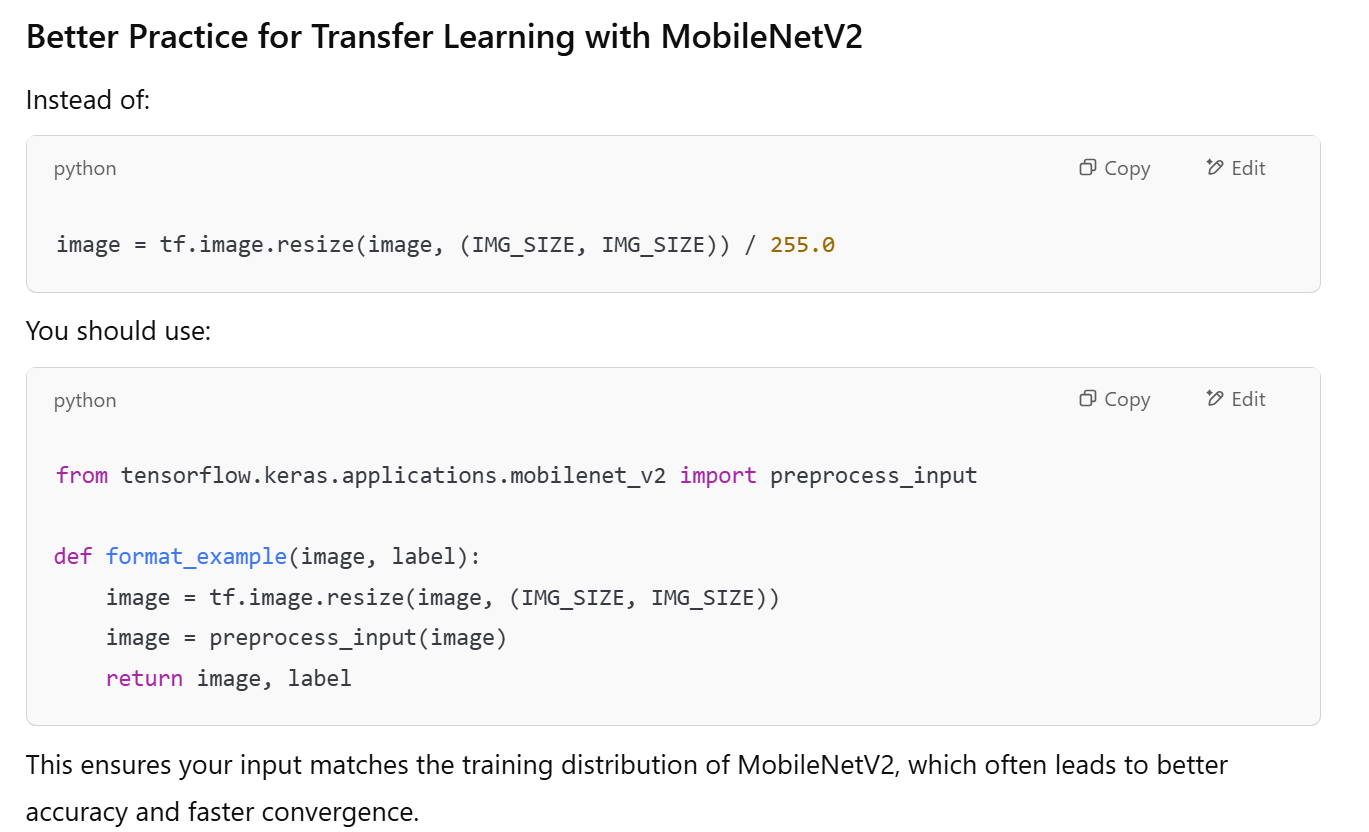

Save as HDF5 File (.h5)
* Saves both architecture + weights + optimizer state
* Easy to load with tf.keras.models.load_model('model_name.h5')
* Portable and good for sharing or deploying with Keras

In [ ]:
model.save('flowers_mobilenetv2.h5')

Save as a TensorFlow SavedModel — (recommended for deployment)
* Creates a directory with all model data
* Better for deployment (e.g., TensorFlow Serving, TF Lite conversion)
* Can be loaded via tf.keras.models.load_model('model_folder')

In [ ]:
model.save('model_folder')  # folder path, no extension

Save Only Weights
* Only saves the trained weights
* You must have the model architecture defined in code to load weights later

In [ ]:
model.save_weights('model_weights.h5')
# Load weights into same architecture
model.load_weights('model_weights.h5')

Save Only Architecture (JSON or YAML)
This doesn’t save the weights — just the structure.

In [ ]:
# Save architecture
json_config = model.to_json()
with open('model_config.json', 'w') as f:
    f.write(json_config)

# Load later
from tensorflow.keras.models import model_from_json
with open('model_config.json') as f:
    json_config = f.read()
model = model_from_json(json_config)

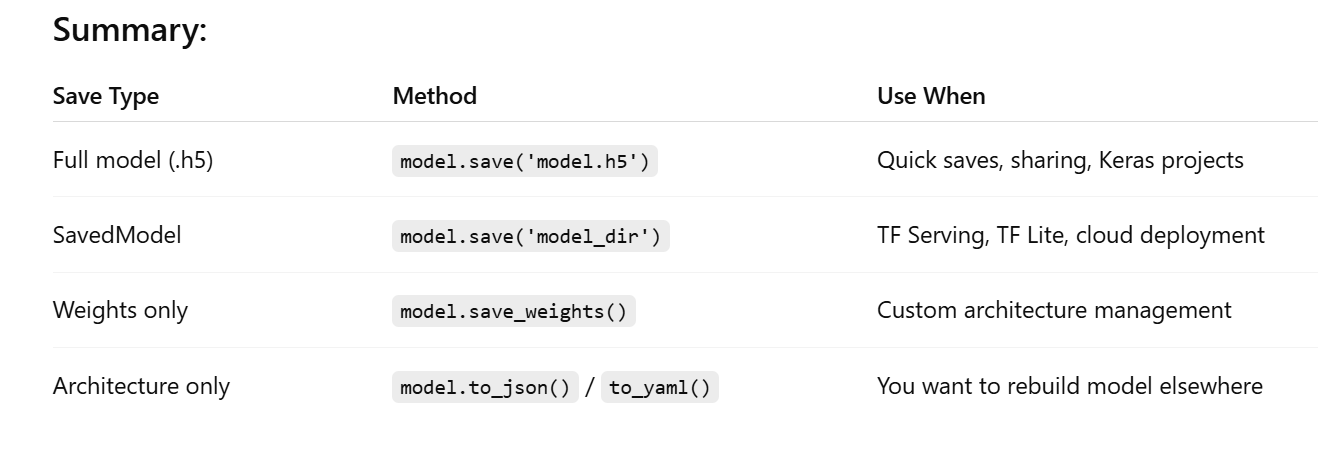